# Segmenting Retinal Blood Vessels With Deep Neural Networks


In [5]:
import skimage as ski
import matplotlib.pyplot as plt
import numpy as np

In [9]:
filename = 'Data/01_dr.jpg'

## Import images

In [23]:
# import images
def loadImage(filename):
    image = ski.io.imread(filename)
    image = image.astype(np.float64)
    if len(image.shape) == 3:
        image = ski.color.rgb2gray(image)
    image /= np.max(image)
    return image

# def saveImage(image, filename):
#     data = (image * 255).astype(np.uint8)
#     ski.io.imsave(filename, data)

def showImage(image):
    plt.imshow(image, cmap='gray')
    plt.show()

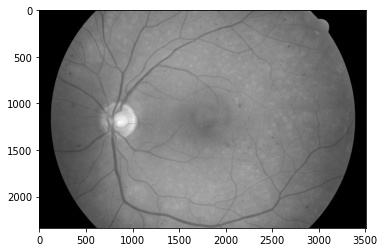

In [28]:
image = loadImage(filename)
showImage(image)

In [149]:
import scipy

def findEdges(image):
	thresh = 0.2
	list = []
	image = scipy.ndimage.gaussian_filter(image, sigma=3)
	image = ski.filters.sobel(image) ** 0.5
	binary = (image > thresh) * 255
	binary = np.uint8(binary)
	return binary


In [155]:
def contrastStretching(image):
	image = ski.exposure.rescale_intensity(image, in_range=(0.1, 0.5))
	return image

def contrast(image):
	image = ski.exposure.equalize_hist(image)
	return image

In [ ]:
def showCurrImage(image, contrast = False, edges = False):
	image = loadImage(filename)
	showImage(image)
	if contrast:
		image = contrast(image)
		showImage(image)
	if edges:
		image = findEdges(image)
		showImage(image)

normal


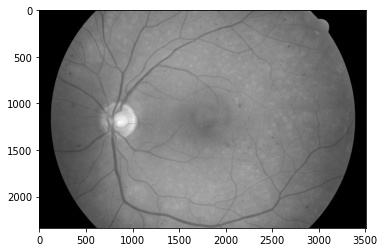

adjust gamma


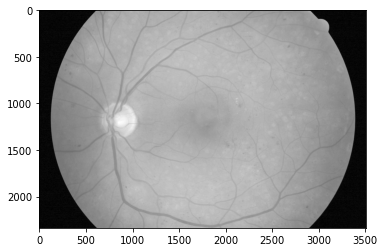

erase_above_average
0.42224540741571065


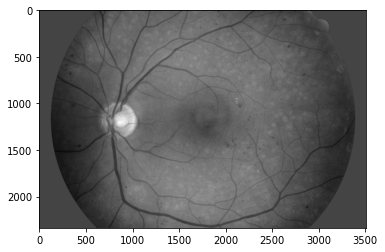

Sobel_h


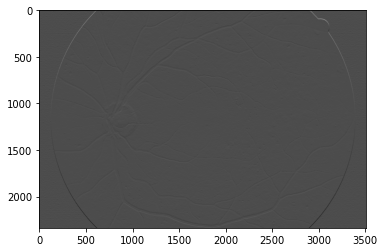

contrast image dark


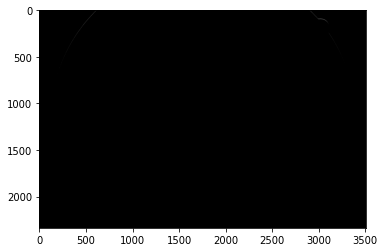

edges


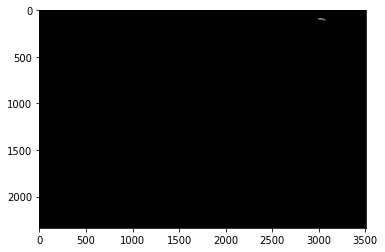

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure, data

image = loadImage(filename)
image_minmax_scaled = exposure.rescale_intensity(image)
# print("max:", image_minmax_scaled.max())
# print("min:", image_minmax_scaled.min())

# interpolacja liniowa
def interpolate(image):
	min, max = image.min(), image.max()
	arr_subtracted = image - min  # Subtract the minimum
	# array([  0,  38,  98, 203, 248], dtype=uint8)
	arr_divided = arr_subtracted / (max - min)  # Divide by new max
	# array([0.        , 0.15322581, 0.39516129, 0.81854839, 1.        ])
	arr_multiplied = arr_divided * 255  # Multiply by dtype max
	# array([  0.        ,  39.07258065, 100.76612903, 208.72983871,
	#        255.        ])
	# Convert dtype to original uint8
	arr_rescaled = np.asarray(arr_multiplied, dtype=image.dtype)
	# array([  0,  39, 100, 208, 255], dtype=uint8)
	return arr_rescaled

def erase_above_average(image):
	average = image.mean(axis=0).mean(axis=0)
	print(average)
	for i in range(len(image)):
		for j in range(len(image[i])):
			if image[i][j] < average/2:
				image[i][j] = average
	return image

print("normal")
showImage(image)

print("adjust gamma")
gamma_img = exposure.adjust_gamma(image, 0.6)
showImage(gamma_img)

print("erase_above_average")
image = erase_above_average(image)
showImage(image)

print("Sobel_h")
image = ski.filters.sobel_h(gamma_img)
showImage(image)


print("contrast image dark")
image = contrastStretching(image)
showImage(image)

print("edges")
image = findEdges(image)
showImage(image)



In [ ]:
# import matplotlib.pyplot as plt
# img = loadImage(filename)
# avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)

# indices = np.argsort(counts)[::-1]   
# freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
# rows = np.int_(img.shape[0]*freqs)

# dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
# for i in range(len(rows) - 1):
#     dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
    
# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
# ax0.imshow(avg_patch)
# ax0.set_title('Average color')
# ax0.axis('off')
# ax1.imshow(dom_patch)
# ax1.set_title('Dominant colors')
# ax1.axis('off')
# plt.show(fig)

In [ ]:
# import scipy


# def findEdges(images):
#     thresh = 0.2
#     list = []
#     for i in range(0, len(images)):
#         images [i] = scipy.ndimage.gaussian_filter(images[i], sigma=3)
#         images[i] = ski.filters.sobel(images[i]) ** 0.5
#         binary = (images[i] > thresh) * 255
#         binary = np.uint8(binary)
#         list.append(binary)
#     return list